# Lab 9 

## Integrantes: 
- **Nombre:** Juan Avila - 20090
- **Nombre:** Sebastian Aristondo - 20880
- **Nombre:** Daniel González - 20293
- **Nombre:** Manuel Archila - 161250
- **Nombre:** Diego Franco - 20240


In [15]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import random as rand
import torch.utils.data as data

## Pr   eparacion de datos

a.  Limpieza de datos: Maneje valores faltantes, anomalías o valores atípicos en el conjunto de datos.


b. Transformación de datos: Convierta los datos a un formato adecuado para modelar, incluyendo normalización o escalado si es necesario.


In [16]:
data = pd.read_csv('./Data/train.csv')
data.head(-10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912985,2017-12-17,10,50,86
912986,2017-12-18,10,50,53
912987,2017-12-19,10,50,54
912988,2017-12-20,10,50,51


In [17]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [19]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


## 2.   Preprocesamiento de datos

a. División de series temporales: Divida el conjunto de datos en conjuntos de entrenamiento, validación y prueba. Para datos de series temporales, asegúrese de que el conjunto de prueba contenga los datos más recientes, que abarquen los 3 meses que desea pronosticar.


b. Generación de secuencias: Cree secuencias de datos, donde cada secuencia representa una ventana fija de datos históricos de ventas y el objetivo correspondiente (el pronóstico de 3 meses).


In [20]:
print('Min date from train set: %s' % data['date'].min().date())
print('Max date from train set: %s' % data['date'].max().date())

ultimo_mes = data['date'].max()
primer_mes = ultimo_mes - pd.DateOffset(months=3)

train = data[data['date'] < primer_mes]
test = data[data['date'] >= primer_mes]

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [21]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
store_daily_sales_test = test.groupby(['store', 'date'], as_index=False)['sales'].sum()

#item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()


In [22]:
store_daily_sales.head(-20)

,store,date,sales
0,1,2013-01-01,1316
1,1,2013-01-02,1264
2,1,2013-01-03,1305
3,1,2013-01-04,1452
4,1,2013-01-05,1499
...,...,...,...
17305,10,2017-09-05,3204
17306,10,2017-09-06,3168
17307,10,2017-09-07,3494
17308,10,2017-09-08,3709


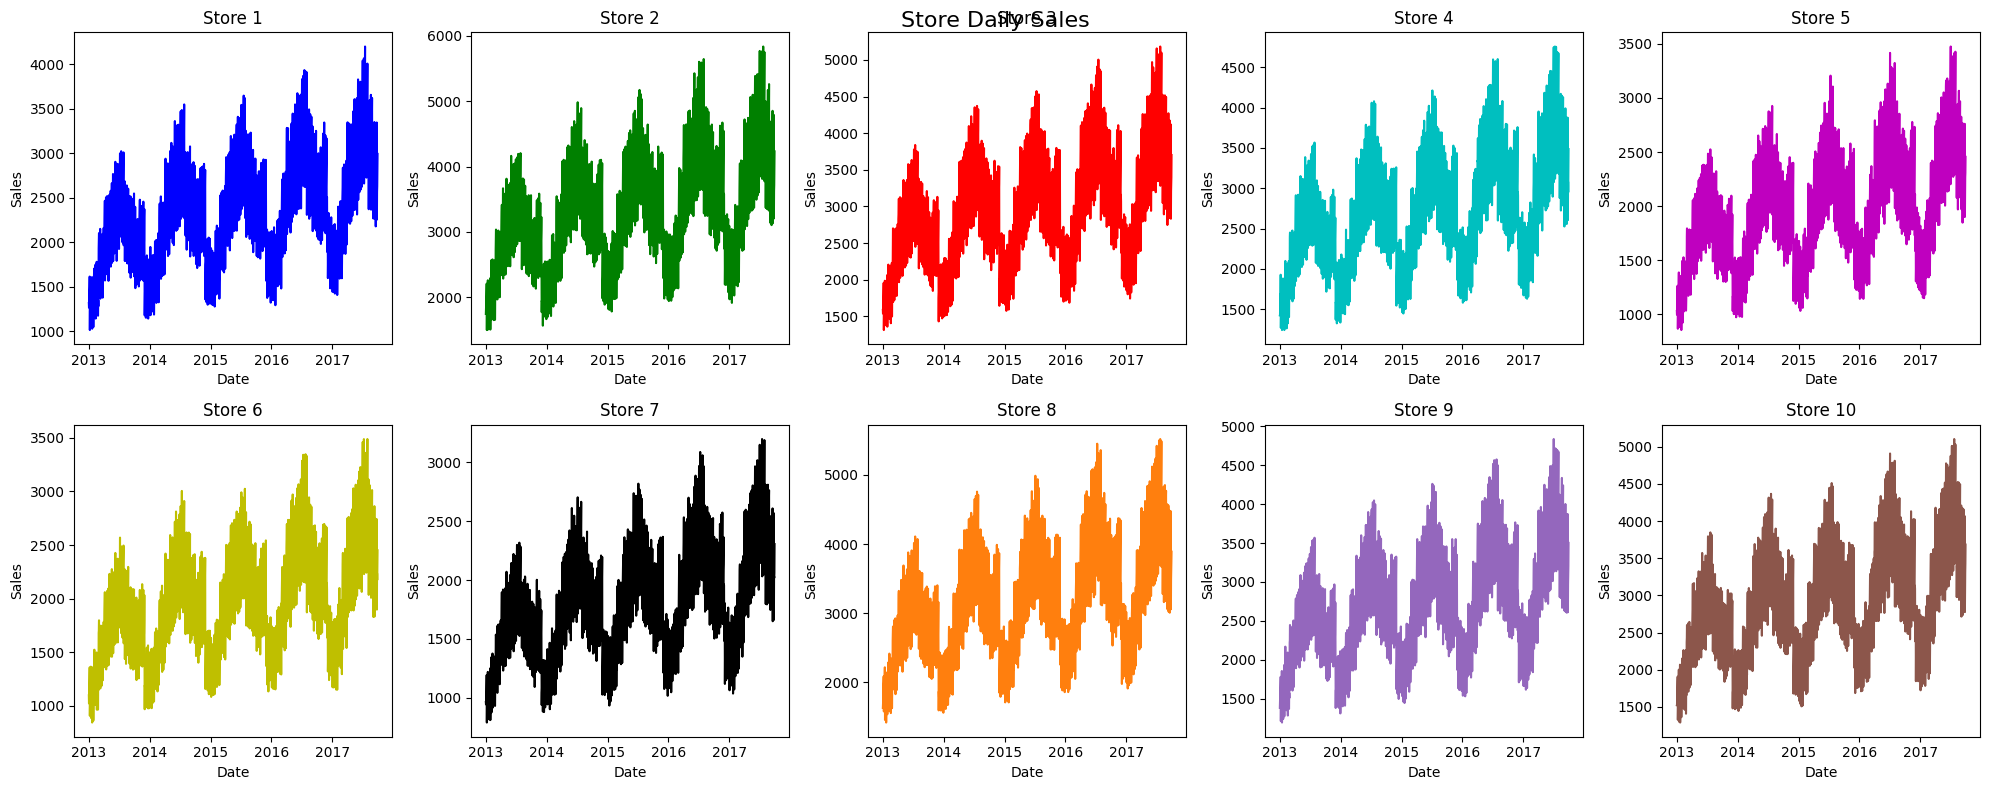

In [23]:
import matplotlib.pyplot as plt

rows = 2  
cols = 5  

fig, axs = plt.subplots(rows, cols, figsize=(20, 8))
colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown']

for i in range(1, 11):
    row = (i - 1) // cols  
    col = (i - 1) % cols  

    temp = store_daily_sales[store_daily_sales.store == i]
    axs[row, col].plot(temp['date'], temp['sales'], color=colores[i-1])
    axs[row, col].set_title('Store %d' % i)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Sales')

plt.tight_layout()
fig.suptitle('Store Daily Sales', fontsize=16)
plt.show()


## 3.   Selección de modelo


Como grupo decidimos que implementaríamos una LSTM

## 4.   Arquitectura modelo

- a. Diseñe la arquitectura de la red neuronal, que puede incluir:
- i. Capas LSTM/GRU/Conv1D con unidades o filtros adecuados.
- ii. Capas adicionales como capas Densas para predicciones finales.
- iii. Capas de dropout para evitar el overfitting.
- iv. Otros componentes como la normalización por batches, funciones de activación y funciones avanzadas como mecanismos de atención.

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [25]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    datos = data[['sales']].values.astype('float32')
    for i in range(data.shape[0] - seq_length):
        seq = datos[i:i+seq_length]
        label = datos[i+1:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
    
    torch_sequences = torch.tensor(sequences)
    torch_labels = torch.tensor(labels)
    return torch_sequences, torch_labels


In [26]:
def get_data(data):
    sequence_length = 10
    X, y = create_sequences(data, sequence_length)
    return X, y


## 5.   Entrenamiento

In [27]:
def graph_loss(loss_train, loss_test):
    # Visualización del rendimiento
    epoch = np.arange(len(loss_train))
    plt.figure()
    plt.plot(epoch, loss_train, 'r', label='Training',)
    plt.plot(epoch, loss_test, 'b', label='Test')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('RMSE')
    plt.show()

In [28]:
def train(loader, n_epochs, model, optimizer, criterion, X_train, y_train, X_test, y_test):
    loss_train = []
    loss_test = []
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            # print(X_batch.shape, y_batch.shape)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:3} loss: {loss.item():10.8f}')
            
        model.eval()
        
        
        with torch.no_grad():
            # Prediccion
            y_pred = model(X_train)
            # Calculo del RMSE - Root Mean Square Error
            train_rmse = np.sqrt(criterion(y_pred, y_train))
            # Prediccion sobre validation
            y_pred = model(X_test)
            # Calculo del RMSE para validation
            test_rmse = np.sqrt(criterion(y_pred, y_test))
            loss_train.append(train_rmse)
            loss_test.append(test_rmse)
        
        
    return loss_train, loss_test

In [36]:
from torch.utils.data import DataLoader

input_size = 1
hidden_layer_size = 1
output_size = 1


for tienda in range(0, 2):
    tienda += 1
    
    LSTM_i = LSTM(input_size, hidden_layer_size, output_size)
    optimizer = optim.Adam(LSTM_i.parameters(), lr=0.001)
    loss_function = nn.MSELoss() 
    
    x_train, y_train = get_data(store_daily_sales[store_daily_sales['store'] == tienda])
    x_test, y_test = get_data(store_daily_sales_test[store_daily_sales_test['store'] == tienda])

    loader = DataLoader((x_train, y_train), batch_size=8, shuffle=True)
    loss_train, loss_test = train(loader, 100, LSTM_i, optimizer, loss_function, x_train, y_train, x_test, y_test)

    graph_loss(loss_train, loss_test)

    # Predicción

    


Epoch 0: train RMSE 2431.4692, test RMSE 2537.0518
Epoch 1: train RMSE 2431.4683, test RMSE 2537.0505
Epoch 2: train RMSE 2431.4673, test RMSE 2537.0496
Epoch 3: train RMSE 2431.4663, test RMSE 2537.0486
Epoch 4: train RMSE 2431.4653, test RMSE 2537.0476
Epoch 5: train RMSE 2431.4644, test RMSE 2537.0466
Epoch 6: train RMSE 2431.4634, test RMSE 2537.0454
Epoch 7: train RMSE 2431.4624, test RMSE 2537.0444
Epoch 8: train RMSE 2431.4614, test RMSE 2537.0435
Epoch 9: train RMSE 2431.4604, test RMSE 2537.0425
Epoch 10: train RMSE 2431.4595, test RMSE 2537.0415
Epoch 11: train RMSE 2431.4585, test RMSE 2537.0410
Epoch 12: train RMSE 2431.4578, test RMSE 2537.0398
Epoch 13: train RMSE 2431.4565, test RMSE 2537.0386
Epoch 14: train RMSE 2431.4556, test RMSE 2537.0376


KeyboardInterrupt: 

# 6.    Evaluación modelo

## 7.   Ajuste hipermarametros

## 8.   Forecasting

## 9.   Visualización

## 10.  Interpretabilidad del modelo